In [1]:
using Turing
using LimberJack
using LinearAlgebra
using CSV
using NPZ
using Plots
using FITSIO
using ForwardDiff
using BenchmarkTools
using DelimitedFiles

┌ Info: Precompiling LimberJack [6b86205d-155a-4b14-b82d-b6a149ea78f2]
└ @ Base loading.jl:1423


In [2]:
files = npzread("../data/DESY1_cls/Cls_meta.npz")
Cls_meta = cls_meta(files)

cls_meta{Vector{Vector{Int64}}}([[1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 2], [2, 3]], [[1, 0, 1, 0], [1, 1, 1, 1], [1, 2, 1, 2], [1, 3, 1, 3], [1, 4, 1, 4], [1, 0, 2, 0], [1, 0, 2, 1], [1, 0, 2, 2], [1, 0, 2, 3], [1, 1, 2, 0]  …  [2, 0, 2, 0], [2, 0, 2, 1], [2, 0, 2, 2], [2, 0, 2, 3], [2, 1, 2, 1], [2, 1, 2, 2], [2, 1, 2, 3], [2, 2, 2, 2], [2, 2, 2, 3], [2, 3, 2, 3]], [[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [1, 6], [1, 7], [1, 8], [1, 9], [2, 6]  …  [6, 6], [6, 7], [6, 8], [6, 9], [7, 7], [7, 8], [7, 9], [8, 8], [8, 9], [9, 9]])

In [3]:
cov_tot = files["cov"]
inv_cov_tot = files["inv_cov"]
data_vector = files["cls"];

In [4]:
#                Omega_b,           Omega_c          n_s,                 h,
#                DESgc__0_gc_b,     DESgc__1_gc_b,   DESgc__2_gc_b,    DESgc__3_gc_b,    DESgc__4_gc_b,
#                DESgc__0_dz,      DESgc__1_dz,      DESgc__2_dz,      DESgc__3_dz,      DESgc__4_dz,
#                wl_ia_A,          wl_ia_eta, 
#                DESwl__0_wl_m,    DESwl__1_wl_m,    DESwl__2_wl_m,    DESwl__3_wl_m,
#                DESwl__0_dz,      DESwl__1_dz,      DESwl__2_dz,      DESwl__3_dz,
#                sigma_8,          Omega_m
carlos_params1 = [4.426868e-02,     2.093138e-01,     8.963611e-01,     8.495440e-01,
                 1.343888e+00,    1.639047e+00,      1.597174e+00,     1.944583e+00,     2.007245e+00,
                -4.679383e-03,   -2.839996e-03,      1.771571e-03,     1.197051e-03,    -5.199799e-03,
                 2.389208e-01,   -6.435288e-01, 
                 1.802722e-03,   -5.508994e-03,     1.952514e-02,    -1.117726e-03,
                -1.744083e-02,    6.777779e-03,    -1.097939e-03,    -4.912315e-03,
                 8.536883e-01,    2.535825e-01];

In [5]:
cls_carlos = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info.npz");
cls_carlos2 = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp.npz");
cls_carlos3 = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp_EH.npz");
cls_carlos4 = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp_EH_noconv.npz");

In [6]:
pars = carlos_params1
nuisances = Dict("b0" => pars[5],
                 "b1" => pars[6],
                 "b2" => pars[7],
                 "b3" => pars[8],
                 "b4" => pars[9],
                 "dz_g0" => pars[10],
                 "dz_g1" => pars[11],
                 "dz_g2" => pars[12],
                 "dz_g3" => pars[13],
                 "dz_g4" => pars[14],
                 "dz_k0" => pars[21],
                 "dz_k1" => pars[22],
                 "dz_k2" => pars[23],
                 "dz_k3" => pars[24],
                 "m0" => pars[17],
                 "m1" => pars[18],
                 "m2" => pars[19],
                 "m3" => pars[20],
                 "A_IA" => pars[15],
                 "alpha_IA" => pars[16]);

In [7]:
function make_cls(pars)
    nuisances = Dict("b0" => pars[5],
                     "b1" => pars[6],
                     "b2" => pars[7],
                     "b3" => pars[8],
                     "b4" => pars[9],
                     "dz_g0" => pars[10],
                     "dz_g1" => pars[11],
                     "dz_g2" => pars[12],
                     "dz_g3" => pars[13],
                     "dz_g4" => pars[14],
                     "dz_k0" => pars[21],
                     "dz_k1" => pars[22],
                     "dz_k2" => pars[23],
                     "dz_k3" => pars[24],
                     "m0" => pars[17],
                     "m1" => pars[18],
                     "m2" => pars[19],
                     "m3" => pars[20],
                     "A_IA" => pars[15],
                     "alpha_IA" => pars[16])

    Ωm = pars[26]
    Ωb = pars[1]
    h = pars[4]
    ns = pars[3]
    s8 = pars[25]
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode="EisHu", Pk_mode="Halofit")#, 
                                     #nk=500, nz=500, nz_pk=500)

    return Theory(cosmology, nuisances, Cls_meta, files).cls

end

make_cls (generic function with 1 method)

In [8]:
function diff_cls_nuisance(dz)
    nuisances = Dict("dz_g2"=> dz)
    cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81,
                                     tk_mode="EisHu", Pk_mode="Halofit")
    cls = Theory(cosmology, nuisances, Cls_meta, files).cls
    return cls
end

function numd_cls_nuisance(dz)
    nuisances1 = Dict("dz_g2"=> dz)
    nuisances2 = Dict("dz_g2"=> dz.-0.0005)
    cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81,
                                     tk_mode="EisHu", Pk_mode="Halofit")
    cls1 = Theory(cosmology, nuisances1, Cls_meta, files).cls
    cls2 = Theory(cosmology, nuisances2, Cls_meta, files).cls
    return (cls1 .- cls2) ./ 0.0005
end

function diff_tracer_nuisance(dz; nzs=files["nz_11"])
    nz = vec(nzs[2:2, :])
    zs = vec(nzs[1:1, :])
    zs_shift = zs .- dz
    sel = zs_shift .> 0.
    cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81, tk_mode="EisHu", Pk_mode="Halofit")
    tracer = WeakLensingTracer(cosmology, zs_shift[sel], nz)
    #w1 = tracer.warr
    w1 = tracer.wint(tracer.chis)
    return w1
end

function numd_tracer_nuisance(dz; nzs=files["nz_11"])
    nz = vec(nzs[2:2, :])
    zs = vec(nzs[1:1, :])
    zs_shift = zs .- dz
    sel = zs_shift .> 0.
    cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81, tk_mode="EisHu", Pk_mode="Halofit")
    tracer1 = WeakLensingTracer(cosmology, zs_shift[sel], nz)
    tracer2 = WeakLensingTracer(cosmology, zs_shift[sel] .- 0.0005, nz)
    #w1 = tracer1.warr
    w1 = tracer1.wint(tracer1.chis)
    #w2 = tracer2.warr
    w2 = tracer2.wint(tracer2.chis)
    return (w2 .- w1) ./ 0.0005
end

function diff_cls2_nuisance(dz; nzs=files["nz_11"])
    nz = vec(nzs[2:2, :])
    zs = vec(nzs[1:1, :])
    ls = files["ls_1010"]
    zs_shift = zs .- dz
    sel = zs_shift .> 0.
    cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81, tk_mode="EisHu", Pk_mode="Halofit")
    tracer1 = WeakLensingTracer(cosmology, zs_shift[sel], nz)
    tracer2 = NumberCountsTracer(cosmology, zs_shift[sel], nz)
    Cls = angularCℓs(cosmology, tracer2, tracer2, ls)
    return Cls
end

function numd_cls2_nuisance(dz; nzs=files["nz_11"])
    nz = vec(nzs[2:2, :])
    zs = vec(nzs[1:1, :])
    ls = files["ls_1010"]
    zs_shift = zs .- dz
    sel = zs_shift .> 0.
    cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81, tk_mode="EisHu", Pk_mode="Halofit")
    tracer1 = WeakLensingTracer(cosmology, zs_shift[sel], nz)
    tracer2 = NumberCountsTracer(cosmology, zs_shift[sel], nz)
    tracer3 = WeakLensingTracer(cosmology, zs_shift[sel] .- 0.0005, nz)
    tracer4 = NumberCountsTracer(cosmology, zs_shift[sel] .- 0.0005, nz)
    Cls1 = angularCℓs(cosmology, tracer2, tracer2, ls)
    Cls2 = angularCℓs(cosmology, tracer4, tracer4, ls)
    return (Cls2 .- Cls1) ./ 0.0005
end



numd_cls2_nuisance (generic function with 1 method)

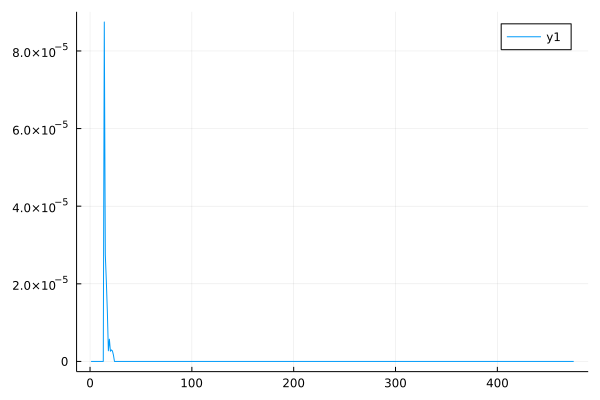

In [9]:
plot(numd_cls_nuisance(-0.01))
#plot!(ForwardDiff.derivative(diff_cls_nuisance, -0.01))

In [10]:
plot(ForwardDiff.derivative(diff_tracer_nuisance, -1))
plot!(numd_tracer_nuisance(-1) )

LoadError: TypeError: in typeassert, expected Float64, got a value of type ForwardDiff.Dual{Nothing, Float64, 1}

In [11]:
plot(ForwardDiff.derivative(diff_cls2_nuisance, -0.1))
plot!(numd_cls2_nuisance(-0.1))

LoadError: TypeError: in typeassert, expected Float64, got a value of type ForwardDiff.Dual{Nothing, Float64, 1}

In [12]:
using Interpolations
function test_func(dz; nzs=files["nz_11"])
    nz = vec(nzs[2:2, :])
    zs = vec(nzs[1:1, :])
    zs_shift = zs .- dz
    nz_int = LinearInterpolation(zs_shift, nz, extrapolation_bc=0)
    res = 200
    z_w = range(0.00001, stop=zs_shift[end], length=res)
    dz_w = (z_w[end]-z_w[1])/res
    nz_w = nz_int(z_w)
    nz_norm = sum(0.5 .* (nz_w[1:res-1] .+ nz_w[2:res]) .* dz_w)
    cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81, tk_mode="EisHu", Pk_mode="Halofit")
    return cosmology.chi(z_w) .* nz_norm #(zs .^2) .* nz_norm
end

function numd_test_func(dz)
    v1 = test_func(dz)
    v2 = test_func(dz-0.0005)
    return (v1-v2)/0.0005
end

numd_test_func (generic function with 1 method)

In [13]:
diff1 = ForwardDiff.derivative(test_func, -0.01) 

200-element Vector{Float64}:
    0.013697713777764218
    5.3015272827004125
   10.82575969561583
   16.592711370768612
   22.098350668927083
   28.209124666625755
   34.5721895031477
   40.30548753566677
   47.02035437042258
   53.98952019189028
   61.211898827718755
   67.27023063746392
   74.83839995520694
    ⋮
 1333.9694236079165
 1335.1466747898764
 1336.3239259718366
 1337.5011771537966
 1338.6784283357565
 1339.8556795177167
 1341.0329306996769
 1342.210181881637
 1343.3874330635965
 1344.5646842455567
 1345.741935427517
 1346.919186609477

In [14]:
diff2 = numd_test_func(-0.01)

200-element Vector{Float64}:
    0.01370080946015706
    5.311170908441909
   10.844913725236438
   16.621243769463945
   22.136200900717995
   28.256098559722886
   34.62815108605355
   40.370435375734814
   47.09402988464717
   54.071785634050684
   61.30261635962597
   67.36947432455054
   74.9458342638718
    ⋮
 1334.630241524792
 1335.809670154049
 1336.989098783306
 1338.168527412563
 1339.347956040001
 1340.527384667439
 1341.706813294877
 1342.886241924134
 1344.065670551572
 1345.2450991826481
 1346.4245278100861
 1347.6039564375242

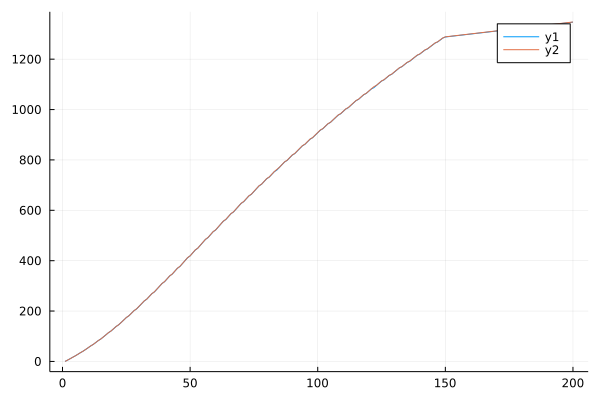

In [15]:
plot(diff1)
plot!(diff2)

In [16]:
cls_jaime1 = make_cls(carlos_params1);

In [17]:
open("jaime_cls.txt", "w") do io
       writedlm(io, cls_jaime1)
end

In [18]:
compa1 = @. abs(cls_carlos["cls"]-cls_jaime1)/cls_carlos["cls"];
compa2 = @. abs(cls_carlos2["cls"]-cls_jaime1)/cls_carlos2["cls"];
compa3 = @. abs(cls_carlos3["cls"]-cls_jaime1)/cls_carlos3["cls"];
compa4 = @. abs(cls_carlos4["cls"]-cls_jaime1)/cls_carlos4["cls"];

println("Mean discrepancy default   ", mean(compa1))
println("Mean discrepancy no itp    ", mean(compa2))
println("Mean discrepancy no itp+EH ", mean(compa3))
println("Mean discrepancy no itp+EH+noconv ", mean(compa4))

Mean discrepancy default   0.020372377257100033
Mean discrepancy no itp    0.016502989884555678
Mean discrepancy no itp+EH 0.010255565692812713
Mean discrepancy no itp+EH+noconv 0.005582106375916865


In [19]:
chi2_carlos = cls_carlos["chi2_nolp"]
chi2_carlos2 = cls_carlos2["chi2_nolp"]
chi2_carlos3 = cls_carlos3["chi2_nolp"]
chi2_carlos4 = cls_carlos4["chi2_nolp"]
println(chi2_carlos)
println(chi2_carlos2)
println(chi2_carlos3)
println(chi2_carlos4)

495.62231927779936
495.00947244084654
495.89420547809317
497.2051355000593


In [20]:
chi2_jaime1 = dot((cls_jaime1 .- data_vector), inv_cov_tot  * (cls_jaime1 .- data_vector))
println(chi2_jaime1)

498.5529771671424


In [21]:
(chi2_jaime1-chi2_carlos4)/chi2_carlos4

0.0027108361737404035

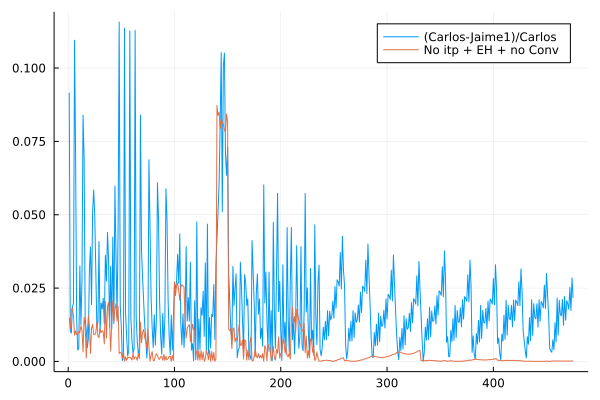

In [22]:
plot(compa1, label="(Carlos-Jaime1)/Carlos")
plot!(compa4, label="No itp + EH + no Conv")

In [23]:
@model function model(data_vector::Vector{Float64})
    Ωm ~ Uniform(0.1, 0.6)
    Ωb = 0.05 #~ Uniform(0.03, 0.07)
    h = 0.67 #~ Uniform(0.6, 0.9)
    s8 = 0.81 #~ Uniform(0.6, 1.0)
    ns = 0.96 #~ Uniform(0.87, 1.07)
    
    #b0 ~ Uniform(0.8, 3.0)
    #b1 ~ Uniform(0.8, 3.0)
    #b2 ~ Uniform(0.8, 3.0)
    #b3 ~ Uniform(0.8, 3.0)
    #b4 ~ Uniform(0.8, 3.0)
    
    dz_g0 ~ TruncatedNormal(0.008, 0.007, -2.0, 2.0)
    dz_g1 ~ TruncatedNormal(-0.005, 0.007, -2.0, 2.0)
    dz_g2 ~ TruncatedNormal(0.006, 0.006, -2.0, 2.0)
    dz_g3 ~ TruncatedNormal(0.0, 0.010, -2.0, 2.0)
    dz_g4 ~ TruncatedNormal(0.0, 0.010, -2.0, 2.0)
    
    #m0 ~ Normal(0.0, 0.035)
    #m1 ~ Normal(0.0, 0.035)
    #m2 ~ Normal(0.0, 0.035)
    #m3 ~ Normal(0.0, 0.035)
    
    #A_IA ~ Uniform(-5, 5) 
    #alpha_IA ~ Uniform(-5, 5)

    nuisances = Dict("dz_g0" => dz_g0,
                     "dz_g1" => dz_g1,
                     "dz_g2" => dz_g2,
                     "dz_g3" => dz_g3,
                     "dz_g4" => dz_g4)
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, s8, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, nuisances, Cls_meta, files).cls
    data_vector ~ MvNormal(theory, cov_tot)
    return data_vector
end;

In [24]:
iterations = 300
nadapts = 100;

In [25]:
chain1 = sample(model(data_vector), MH(), iterations,
            nadapt=nadapts, progress=true; save_state=true);

LoadError: UndefVarError: cosmology not defined

In [25]:
chain3 = sample(model(data_vector), NUTS(5, 0.1), iterations,
                progress=true; save_state=true);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /home/jaime/.julia/packages/Turing/uAz5c/src/infere

LoadError: InterruptException: